In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('QVI_data.csv')

# Display the first few rows of the dataset
data.head()


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [2]:
# Convert date column to datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# Calculate metrics
metrics = data.groupby(['STORE_NBR', data['DATE'].dt.to_period('M')]).agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': pd.Series.nunique,
    'TXN_ID': 'count'
}).reset_index()

metrics.columns = ['STORE_NBR', 'MONTH', 'TOTAL_SALES', 'TOTAL_CUSTOMERS', 'TOTAL_TRANSACTIONS']
metrics['AVG_TXN_PER_CUSTOMER'] = metrics['TOTAL_TRANSACTIONS'] / metrics['TOTAL_CUSTOMERS']

# Display the first few rows of the metrics
metrics.head()


,STORE_NBR,MONTH,TOTAL_SALES,TOTAL_CUSTOMERS,TOTAL_TRANSACTIONS,AVG_TXN_PER_CUSTOMER
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


In [4]:
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr

def select_control_store(trial_store, metrics, method='euclidean'):
    trial_data = metrics[metrics['STORE_NBR'] == trial_store].groupby('STORE_NBR').mean()
    
    def calculate_similarity(store):
        control_data = metrics[metrics['STORE_NBR'] == store].groupby('STORE_NBR').mean()
        if method == 'euclidean':
            dist = euclidean(trial_data[['TOTAL_SALES', 'TOTAL_CUSTOMERS', 'AVG_TXN_PER_CUSTOMER']].values.flatten(), 
                             control_data[['TOTAL_SALES', 'TOTAL_CUSTOMERS', 'AVG_TXN_PER_CUSTOMER']].values.flatten())
            return dist
        elif method == 'pearson':
            corr_sales, _ = pearsonr(trial_data['TOTAL_SALES'], control_data['TOTAL_SALES'])
            corr_customers, _ = pearsonr(trial_data['TOTAL_CUSTOMERS'], control_data['TOTAL_CUSTOMERS'])
            corr_avg_txn, _ = pearsonr(trial_data['AVG_TXN_PER_CUSTOMER'], control_data['AVG_TXN_PER_CUSTOMER'])
            return 1 - (corr_sales + corr_customers + corr_avg_txn) / 3
    
    other_stores = metrics['STORE_NBR'].unique().tolist()
    other_stores.remove(trial_store)
    
    similarities = {store: calculate_similarity(store) for store in other_stores}
    control_store = min(similarities, key=similarities.get)
    
    return control_store

# Example usage
control_store_77 = select_control_store(77, metrics, method='euclidean')
control_store_86 = select_control_store(86, metrics, method='euclidean')
control_store_88 = select_control_store(88, metrics, method='euclidean')

control_store_77, control_store_86, control_store_88


(46, 247, 165)

C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


TypeError: Invalid object type at position 0

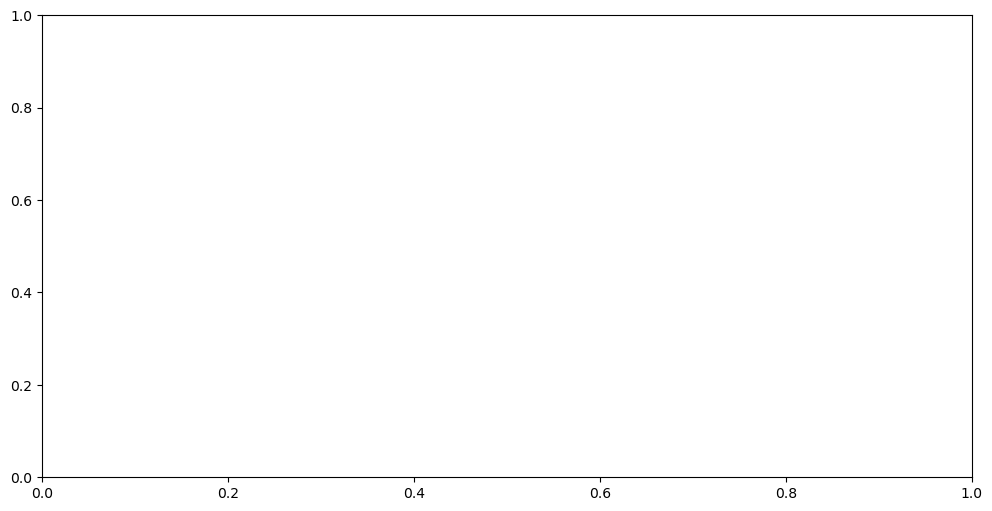

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Convert columns to numeric and handle non-numeric values
metrics['TOTAL_SALES'] = pd.to_numeric(metrics['TOTAL_SALES'], errors='coerce')
metrics['TOTAL_CUSTOMERS'] = pd.to_numeric(metrics['TOTAL_CUSTOMERS'], errors='coerce')
metrics['AVG_TXN_PER_CUSTOMER'] = pd.to_numeric(metrics['AVG_TXN_PER_CUSTOMER'], errors='coerce')

def compare_stores(trial_store, control_store, metrics):
    trial_data = metrics[metrics['STORE_NBR'] == trial_store]
    control_data = metrics[metrics['STORE_NBR'] == control_store]
    
    trial_period = trial_data['MONTH'].max()  # Assuming the latest month is the trial period
    pre_trial_data = metrics[metrics['MONTH'] < trial_period]
    
    # Plot total sales comparison
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='MONTH', y='TOTAL_SALES', data=trial_data, label=f'Trial Store {trial_store}')
    sns.lineplot(x='MONTH', y='TOTAL_SALES', data=control_data, label=f'Control Store {control_store}')
    plt.title(f'Total Sales Comparison: Trial Store {trial_store} vs Control Store {control_store}')
    plt.legend()
    plt.show()
    
    # Perform t-test
    trial_sales = trial_data[trial_data['MONTH'] == trial_period]['TOTAL_SALES']
    control_sales = control_data[control_data['MONTH'] == trial_period]['TOTAL_SALES']
    t_stat, p_value = ttest_ind(trial_sales, control_sales, nan_policy='omit')
    
    print(f'T-test results: t-statistic={t_stat}, p-value={p_value}')
    
    return t_stat, p_value

# Example comparison
compare_stores(77, control_store_77, metrics)
compare_stores(86, control_store_86, metrics)
compare_stores(88, control_store_88, metrics)


In [7]:
# Inspect data types
print(metrics.dtypes)

# Check for non-numeric values in the columns
print(metrics['TOTAL_SALES'].apply(type).value_counts())
print(metrics['TOTAL_CUSTOMERS'].apply(type).value_counts())
print(metrics['AVG_TXN_PER_CUSTOMER'].apply(type).value_counts())


STORE_NBR                   int64
MONTH                   period[M]
TOTAL_SALES               float64
TOTAL_CUSTOMERS             int64
TOTAL_TRANSACTIONS          int64
AVG_TXN_PER_CUSTOMER      float64
dtype: object
TOTAL_SALES
<class 'float'>    3169
Name: count, dtype: int64
TOTAL_CUSTOMERS
<class 'int'>    3169
Name: count, dtype: int64
AVG_TXN_PER_CUSTOMER
<class 'float'>    3169
Name: count, dtype: int64


In [8]:
# Convert columns to numeric and handle non-numeric values
metrics['TOTAL_SALES'] = pd.to_numeric(metrics['TOTAL_SALES'], errors='coerce')
metrics['TOTAL_CUSTOMERS'] = pd.to_numeric(metrics['TOTAL_CUSTOMERS'], errors='coerce')
metrics['AVG_TXN_PER_CUSTOMER'] = pd.to_numeric(metrics['AVG_TXN_PER_CUSTOMER'], errors='coerce')

# Drop rows with NaN values in these columns
metrics.dropna(subset=['TOTAL_SALES', 'TOTAL_CUSTOMERS', 'AVG_TXN_PER_CUSTOMER'], inplace=True)


In [9]:
# Ensure MONTH column is in datetime format if not already
metrics['MONTH'] = pd.to_datetime(metrics['MONTH'], errors='coerce')

# Check for any NaT values and drop them
metrics.dropna(subset=['MONTH'], inplace=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


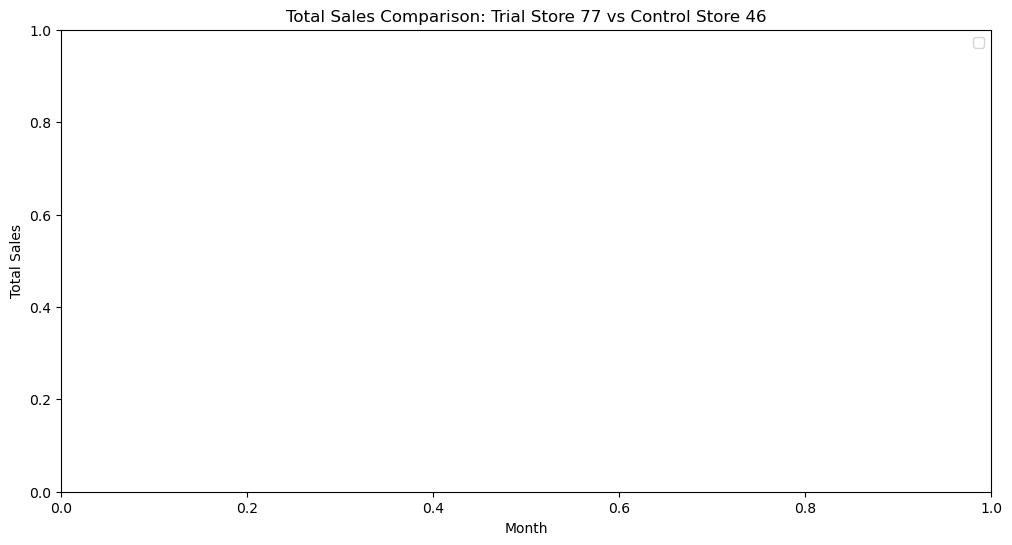

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


T-test results for Store 77 vs Control Store 46:
T-statistic: nan, P-value: nan


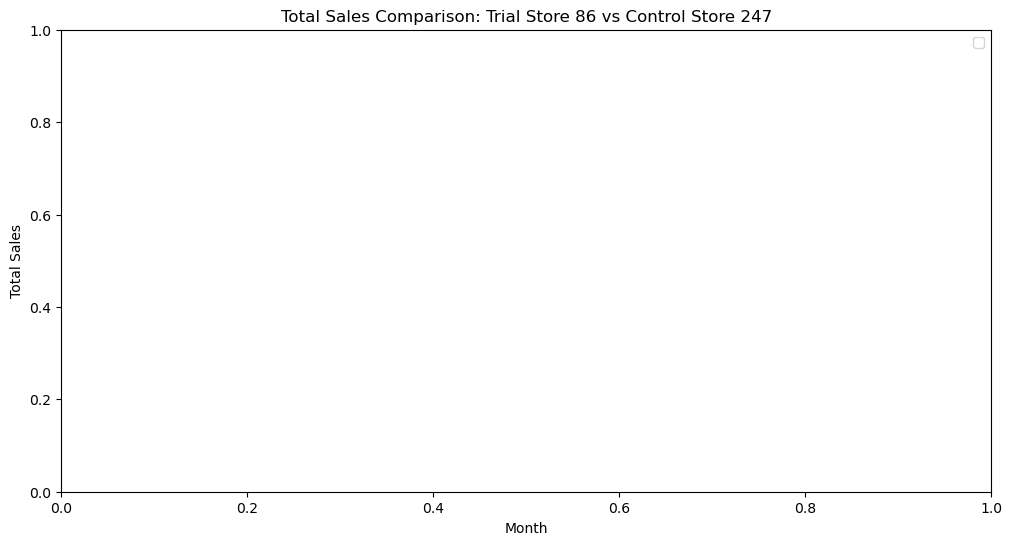

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


T-test results for Store 86 vs Control Store 247:
T-statistic: nan, P-value: nan


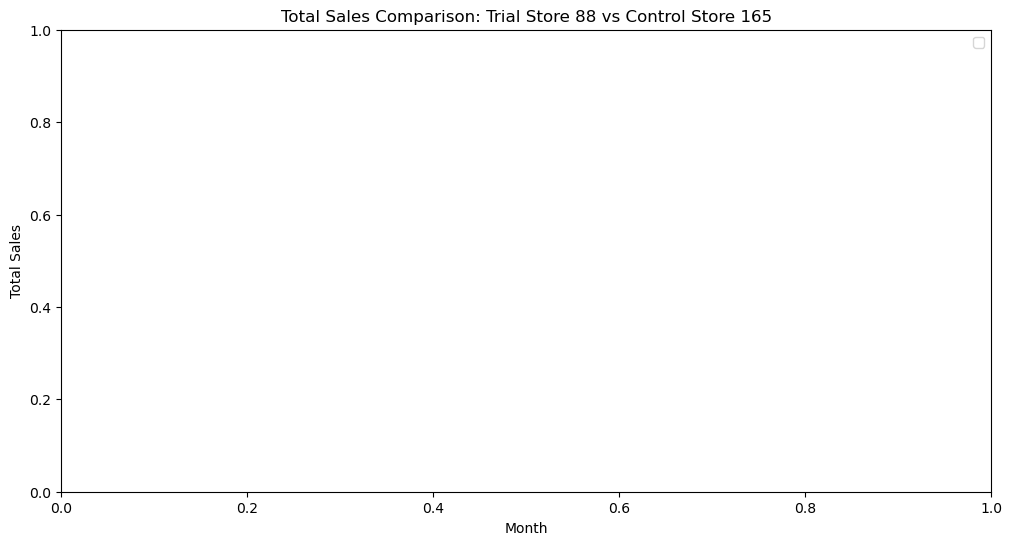

T-test results for Store 88 vs Control Store 165:
T-statistic: nan, P-value: nan


(nan, nan)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

def compare_stores(trial_store, control_store, metrics):
    trial_data = metrics[metrics['STORE_NBR'] == trial_store]
    control_data = metrics[metrics['STORE_NBR'] == control_store]
    
    trial_period = trial_data['MONTH'].max()  # Assuming the latest month is the trial period
    pre_trial_data = metrics[metrics['MONTH'] < trial_period]
    
    # Plot total sales comparison
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='MONTH', y='TOTAL_SALES', data=trial_data, label=f'Trial Store {trial_store}')
    sns.lineplot(x='MONTH', y='TOTAL_SALES', data=control_data, label=f'Control Store {control_store}')
    plt.title(f'Total Sales Comparison: Trial Store {trial_store} vs Control Store {control_store}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()
    
    # Perform t-test
    t_stat, p_value = ttest_ind(trial_data['TOTAL_SALES'], control_data['TOTAL_SALES'])
    print(f"T-test results for Store {trial_store} vs Control Store {control_store}:")
    print(f"T-statistic: {t_stat}, P-value: {p_value}")
    
    return t_stat, p_value

# Example comparison
compare_stores(77, control_store_77, metrics)
compare_stores(86, control_store_86, metrics)
compare_stores(88, control_store_88, metrics)


In [11]:
def verify_data_availability(store, metrics):
    store_data = metrics[metrics['STORE_NBR'] == store]
    print(f"Data availability for store {store}:")
    print(store_data)

# Check data for trial and control stores
verify_data_availability(77, metrics)
verify_data_availability(control_store_77, metrics)
verify_data_availability(86, metrics)
verify_data_availability(control_store_86, metrics)
verify_data_availability(88, metrics)
verify_data_availability(control_store_88, metrics)


Data availability for store 77:
Empty DataFrame
Columns: [STORE_NBR, MONTH, TOTAL_SALES, TOTAL_CUSTOMERS, TOTAL_TRANSACTIONS, AVG_TXN_PER_CUSTOMER]
Index: []
Data availability for store 46:
Empty DataFrame
Columns: [STORE_NBR, MONTH, TOTAL_SALES, TOTAL_CUSTOMERS, TOTAL_TRANSACTIONS, AVG_TXN_PER_CUSTOMER]
Index: []
Data availability for store 86:
Empty DataFrame
Columns: [STORE_NBR, MONTH, TOTAL_SALES, TOTAL_CUSTOMERS, TOTAL_TRANSACTIONS, AVG_TXN_PER_CUSTOMER]
Index: []
Data availability for store 247:
Empty DataFrame
Columns: [STORE_NBR, MONTH, TOTAL_SALES, TOTAL_CUSTOMERS, TOTAL_TRANSACTIONS, AVG_TXN_PER_CUSTOMER]
Index: []
Data availability for store 88:
Empty DataFrame
Columns: [STORE_NBR, MONTH, TOTAL_SALES, TOTAL_CUSTOMERS, TOTAL_TRANSACTIONS, AVG_TXN_PER_CUSTOMER]
Index: []
Data availability for store 165:
Empty DataFrame
Columns: [STORE_NBR, MONTH, TOTAL_SALES, TOTAL_CUSTOMERS, TOTAL_TRANSACTIONS, AVG_TXN_PER_CUSTOMER]
Index: []


In [12]:
# Display the first few rows of the metrics DataFrame
print(metrics.head())

# Display the unique store numbers in the DataFrame
print(metrics['STORE_NBR'].unique())


Empty DataFrame
Columns: [STORE_NBR, MONTH, TOTAL_SALES, TOTAL_CUSTOMERS, TOTAL_TRANSACTIONS, AVG_TXN_PER_CUSTOMER]
Index: []
[]


In [14]:
# Load the original data
data = pd.read_csv('QVI_data.csv')

# Display the first few rows of the original data
print(data.head())

# Display the columns in the original data
print(data.columns)

# Display unique store numbers in the original data
print(data['STORE_NBR'].unique())

   LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000  2018-10-17          1       1         5   
1            1002  2018-09-16          1       2        58   
2            1003  2019-03-07          1       3        52   
3            1003  2019-03-08          1       4       106   
4            1004  2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
4          WW Original Stacked Chips 160g         1        1.9        160   

        BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0     NATURAL  YOUNG SINGLES/COUPLES          Premium  
1         RRD  YOUNG SINGLES/COUPLES       Mainstrea

In [15]:
# Check the data types of the columns
print(data.dtypes)

# Convert store numbers to integers if necessary
data['STORE_NBR'] = data['STORE_NBR'].astype(int)

# Check for any missing values
print(data.isnull().sum())

LYLTY_CARD_NBR        int64
DATE                 object
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
PACK_SIZE             int64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object
LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


In [17]:
# Load the original data
data = pd.read_csv('QVI_data.csv')

# Create a 'MONTH' column from the 'DATE' column
data['MONTH'] = pd.to_datetime(data['DATE']).dt.to_period('M')

# Recalculate metrics
metrics = data.groupby(['STORE_NBR', 'MONTH']).agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID': 'count'
}).reset_index()

metrics['AVG_TXN_PER_CUSTOMER'] = metrics['TXN_ID'] / metrics['LYLTY_CARD_NBR']
metrics.rename(columns={
    'TOT_SALES': 'TOTAL_SALES',
    'LYLTY_CARD_NBR': 'TOTAL_CUSTOMERS',
    'TXN_ID': 'TOTAL_TRANSACTIONS'
}, inplace=True)

# Display the first few rows of the recalculated metrics
print(metrics.head())

# Display the unique store numbers in the recalculated metrics
print(metrics['STORE_NBR'].unique())

   STORE_NBR    MONTH  TOTAL_SALES  TOTAL_CUSTOMERS  TOTAL_TRANSACTIONS  \
0          1  2018-07        206.9               49                  52   
1          1  2018-08        176.1               42                  43   
2          1  2018-09        278.8               59                  62   
3          1  2018-10        188.1               44                  45   
4          1  2018-11        192.6               46                  47   

   AVG_TXN_PER_CUSTOMER  
0              1.061224  
1              1.023810  
2              1.050847  
3              1.022727  
4              1.021739  
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97

In [18]:
# Check data availability for specific stores
trial_stores = [77, 86, 88]
control_stores = [46, 247, 165]

for store in trial_stores + control_stores:
    store_data = metrics[metrics['STORE_NBR'] == store]
    print(f"Data availability for store {store}:")
    print(store_data)


Data availability for store 77:
     STORE_NBR    MONTH  TOTAL_SALES  TOTAL_CUSTOMERS  TOTAL_TRANSACTIONS  \
880         77  2018-07        296.8               51                  55   
881         77  2018-08        255.5               47                  48   
882         77  2018-09        225.2               42                  44   
883         77  2018-10        204.5               37                  38   
884         77  2018-11        245.3               41                  44   
885         77  2018-12        267.3               46                  49   
886         77  2019-01        204.4               35                  39   
887         77  2019-02        235.0               45                  45   
888         77  2019-03        278.5               50                  55   
889         77  2019-04        263.5               47                  48   
890         77  2019-05        299.3               55                  56   
891         77  2019-06        264.7        

In [20]:
df['DATE'] = pd.to_datetime(df['DATE'])


NameError: name 'df' is not defined

In [22]:
# Convert the MONTH column to a timestamp if it is a PeriodDtype
if metrics['MONTH'].dtype == 'period[M]':
    metrics['MONTH'] = metrics['MONTH'].dt.to_timestamp()
else:
    metrics['MONTH'] = pd.to_datetime(metrics['MONTH'], format='%Y-%m')


In [23]:
# Check for NaN values and invalid types in metrics DataFrame
print(metrics.isna().sum())

# Convert relevant columns to appropriate types if necessary
metrics['TOTAL_SALES'] = pd.to_numeric(metrics['TOTAL_SALES'], errors='coerce')
metrics['TOTAL_CUSTOMERS'] = pd.to_numeric(metrics['TOTAL_CUSTOMERS'], errors='coerce')
metrics['TOTAL_TRANSACTIONS'] = pd.to_numeric(metrics['TOTAL_TRANSACTIONS'], errors='coerce')
metrics['AVG_TXN_PER_CUSTOMER'] = pd.to_numeric(metrics['AVG_TXN_PER_CUSTOMER'], errors='coerce')

# Drop rows with NaN values that can't be converted
metrics = metrics.dropna(subset=['TOTAL_SALES', 'TOTAL_CUSTOMERS', 'TOTAL_TRANSACTIONS', 'AVG_TXN_PER_CUSTOMER'])


STORE_NBR               0
MONTH                   0
TOTAL_SALES             0
TOTAL_CUSTOMERS         0
TOTAL_TRANSACTIONS      0
AVG_TXN_PER_CUSTOMER    0
dtype: int64


In [24]:
print(metrics.dtypes)


STORE_NBR                        int64
MONTH                   datetime64[ns]
TOTAL_SALES                    float64
TOTAL_CUSTOMERS                  int64
TOTAL_TRANSACTIONS               int64
AVG_TXN_PER_CUSTOMER           float64
dtype: object


C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

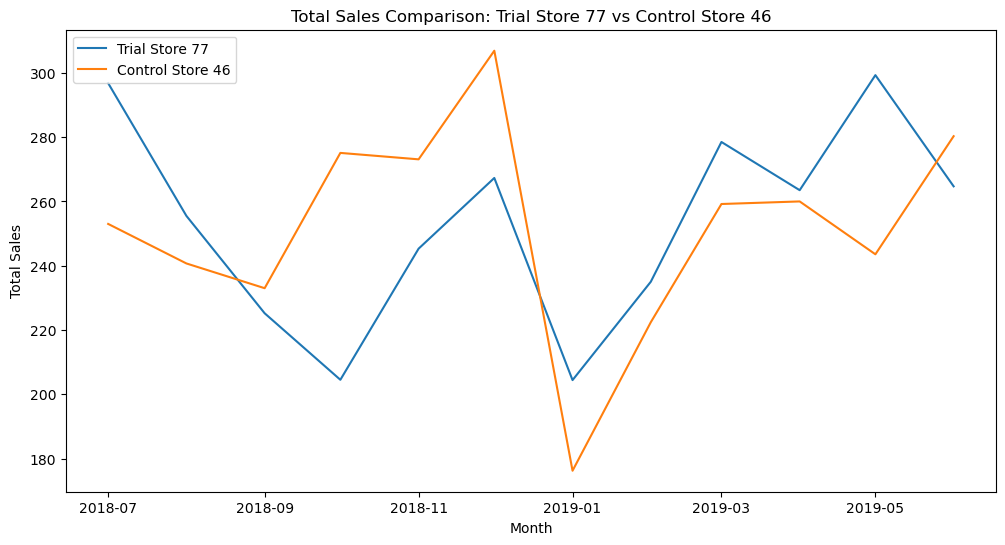

C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

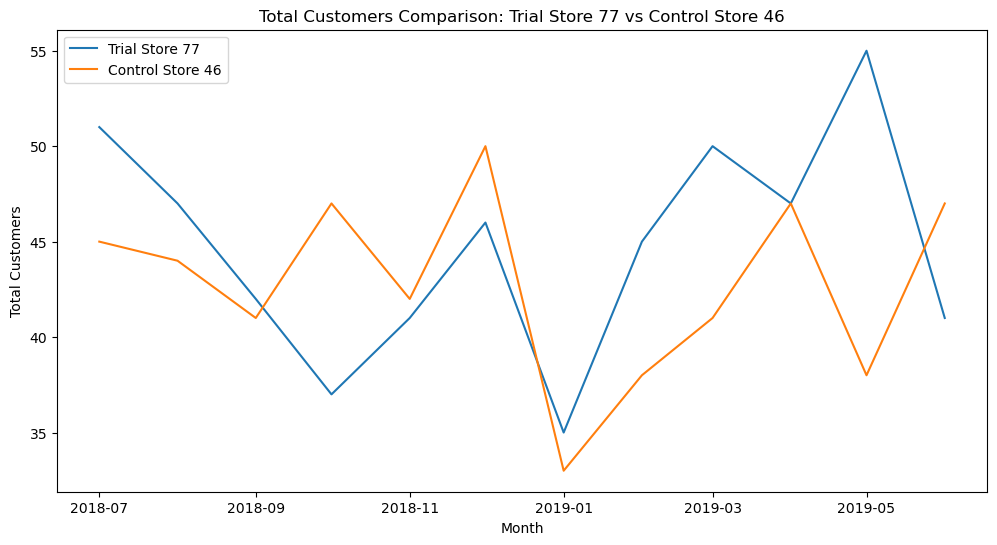

Statistical comparison of TOTAL_SALES:
 t-statistic = 0.10418375320552405, p-value = 0.917969440931093


C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

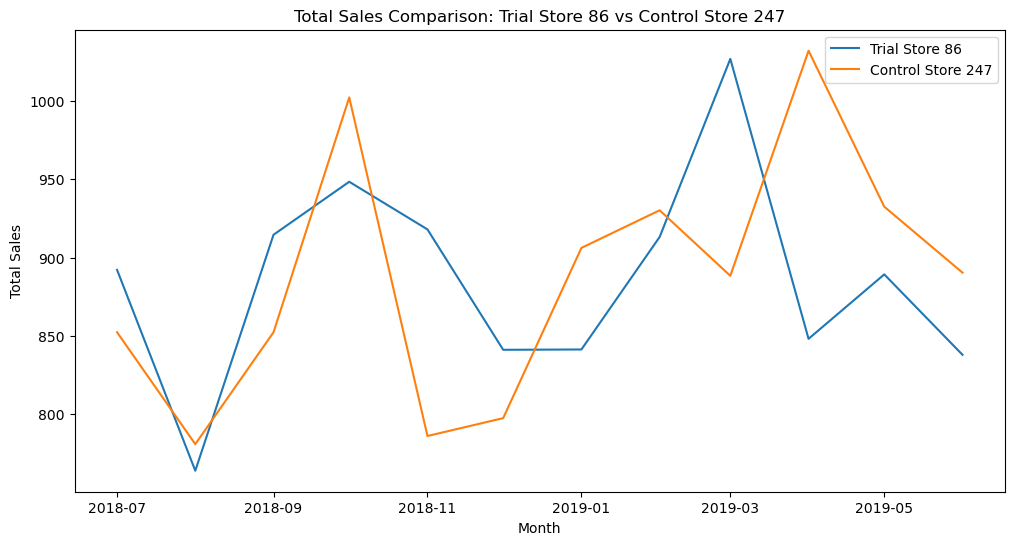

C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

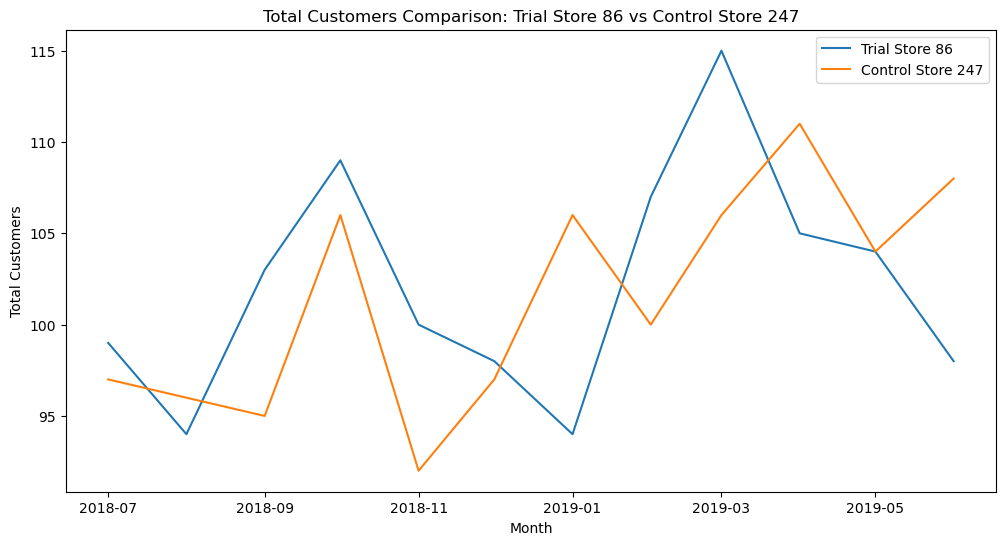

Statistical comparison of TOTAL_SALES:
 t-statistic = -0.04475898277704256, p-value = 0.9647161598977756


C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

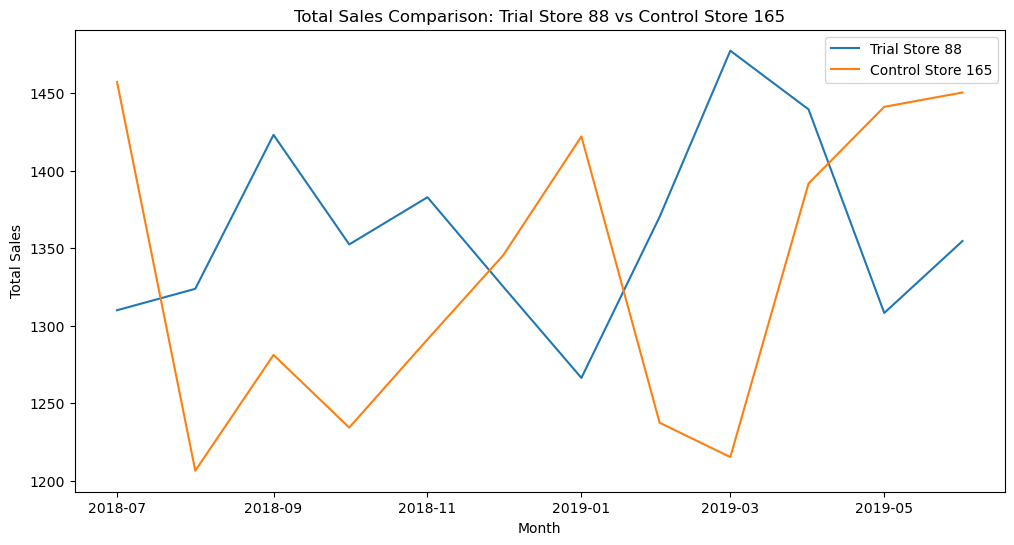

C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Tonye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

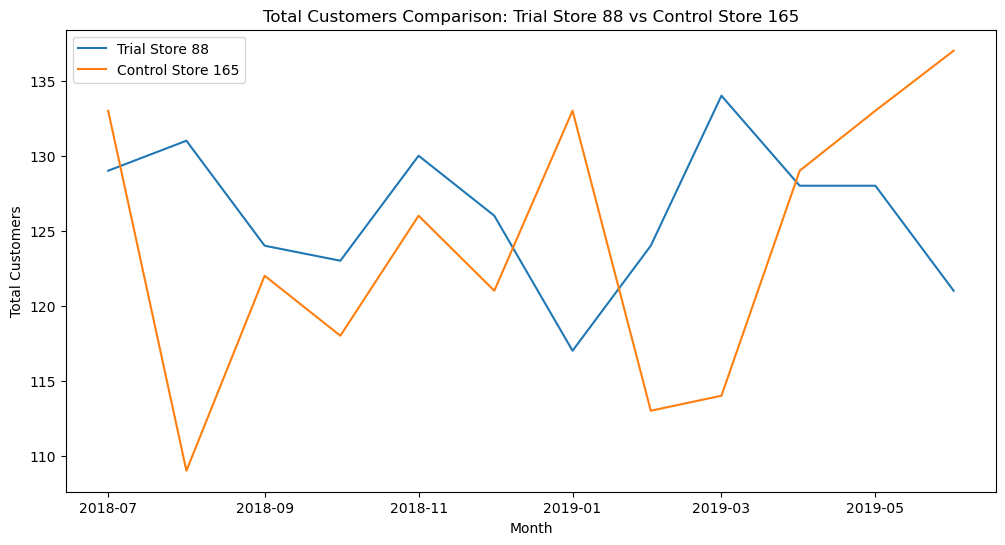

Statistical comparison of TOTAL_SALES:
 t-statistic = 0.8991550085580011, p-value = 0.38015152066183844


(0.8991550085580011, 0.38015152066183844)

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def compare_stores(trial_store, control_store, metrics):
    trial_data = metrics[metrics['STORE_NBR'] == trial_store]
    control_data = metrics[metrics['STORE_NBR'] == control_store]

    # Plot total sales comparison
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='MONTH', y='TOTAL_SALES', data=trial_data, label=f'Trial Store {trial_store}')
    sns.lineplot(x='MONTH', y='TOTAL_SALES', data=control_data, label=f'Control Store {control_store}')
    plt.title(f'Total Sales Comparison: Trial Store {trial_store} vs Control Store {control_store}')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()

    # Plot total customers comparison
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='MONTH', y='TOTAL_CUSTOMERS', data=trial_data, label=f'Trial Store {trial_store}')
    sns.lineplot(x='MONTH', y='TOTAL_CUSTOMERS', data=control_data, label=f'Control Store {control_store}')
    plt.title(f'Total Customers Comparison: Trial Store {trial_store} vs Control Store {control_store}')
    plt.xlabel('Month')
    plt.ylabel('Total Customers')
    plt.legend()
    plt.show()

    # Statistical comparison
    t_stat, p_value = stats.ttest_ind(trial_data['TOTAL_SALES'], control_data['TOTAL_SALES'], equal_var=False)
    print(f'Statistical comparison of TOTAL_SALES:\n t-statistic = {t_stat}, p-value = {p_value}')
    return t_stat, p_value

# Example comparison
compare_stores(77, 46, metrics)
compare_stores(86, 247, metrics)
compare_stores(88, 165, metrics)


In [26]:
# Convert infinite values to NaN in the metrics DataFrame
metrics.replace([np.inf, -np.inf], np.nan, inplace=True)

# Re-check for NaN values and handle them appropriately
print(metrics.isna().sum())

# Drop rows with NaN values that can't be converted
metrics = metrics.dropna(subset=['TOTAL_SALES', 'TOTAL_CUSTOMERS', 'TOTAL_TRANSACTIONS', 'AVG_TXN_PER_CUSTOMER'])


NameError: name 'np' is not defined

In [27]:
import numpy as np

# Convert infinite values to NaN in the metrics DataFrame
metrics.replace([np.inf, -np.inf], np.nan, inplace=True)

# Re-check for NaN values and handle them appropriately
print(metrics.isna().sum())

# Drop rows with NaN values that can't be converted
metrics = metrics.dropna(subset=['TOTAL_SALES', 'TOTAL_CUSTOMERS', 'TOTAL_TRANSACTIONS', 'AVG_TXN_PER_CUSTOMER'])


STORE_NBR               0
MONTH                   0
TOTAL_SALES             0
TOTAL_CUSTOMERS         0
TOTAL_TRANSACTIONS      0
AVG_TXN_PER_CUSTOMER    0
dtype: int64


In [29]:
import numpy as np

# Convert infinite values to NaN in the metrics DataFrame
metrics.replace([np.inf, -np.inf], np.nan, inplace=True)

# Re-check for NaN values and handle them appropriately
print(metrics.isna().sum())

# Drop rows with NaN values that can't be converted
metrics = metrics.dropna(subset=['TOTAL_SALES', 'TOTAL_CUSTOMERS', 'TOTAL_TRANSACTIONS', 'AVG_TXN_PER_CUSTOMER'])


STORE_NBR               0
MONTH                   0
TOTAL_SALES             0
TOTAL_CUSTOMERS         0
TOTAL_TRANSACTIONS      0
AVG_TXN_PER_CUSTOMER    0
dtype: int64


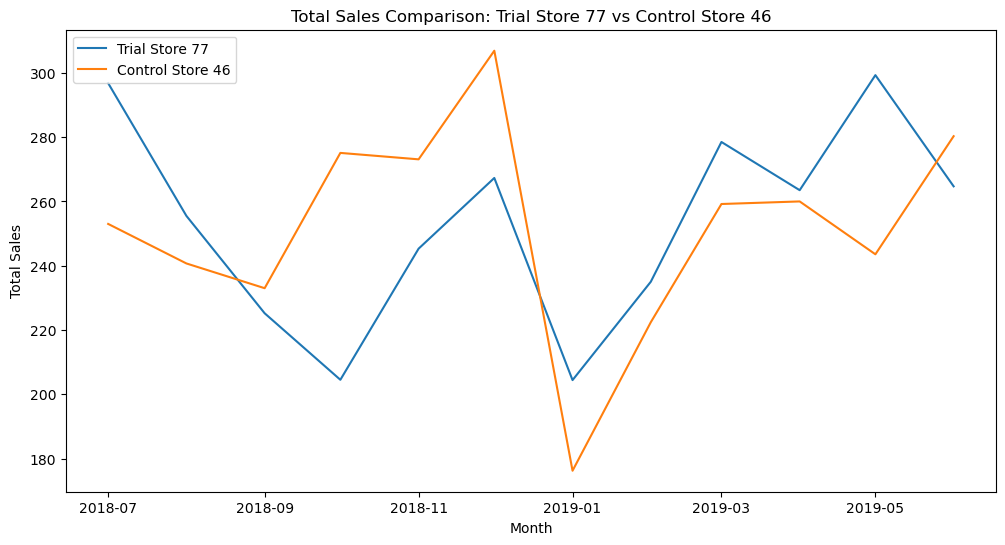

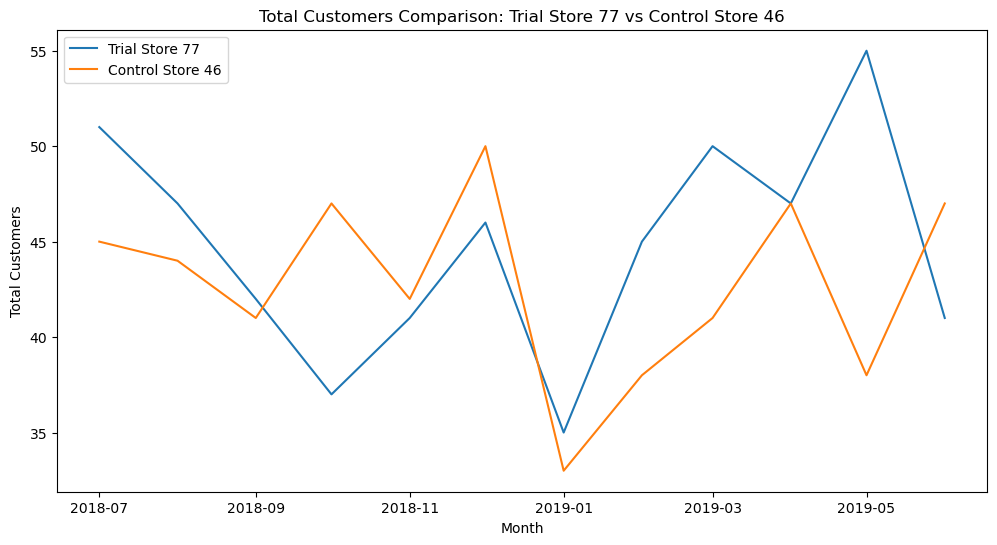

Statistical comparison of TOTAL_SALES:
 t-statistic = 0.10418375320552405, p-value = 0.917969440931093


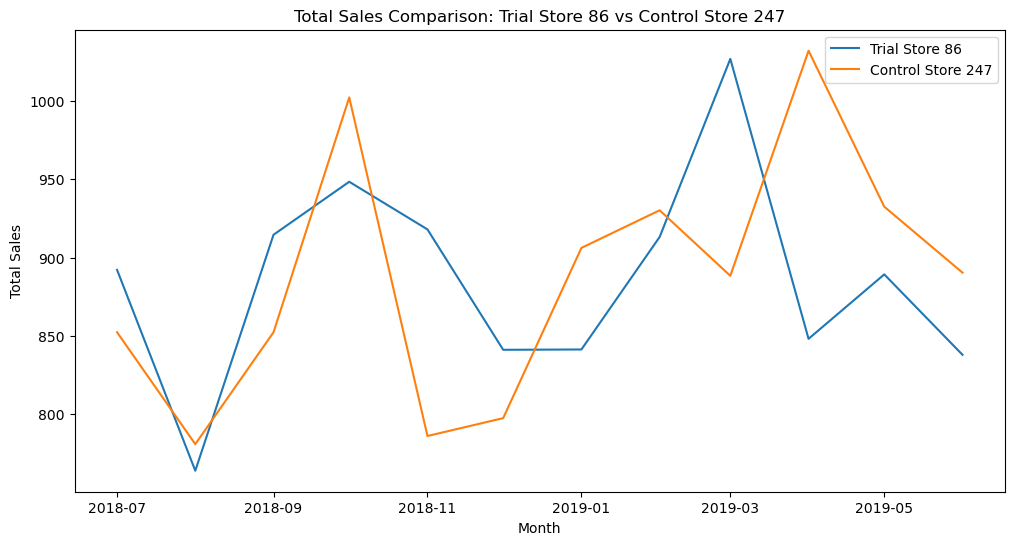

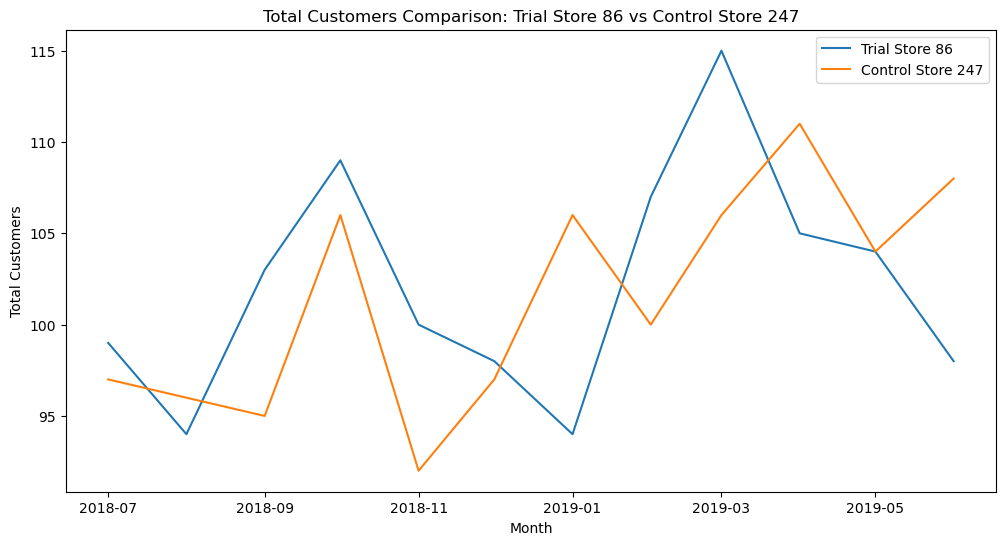

Statistical comparison of TOTAL_SALES:
 t-statistic = -0.04475898277704256, p-value = 0.9647161598977756


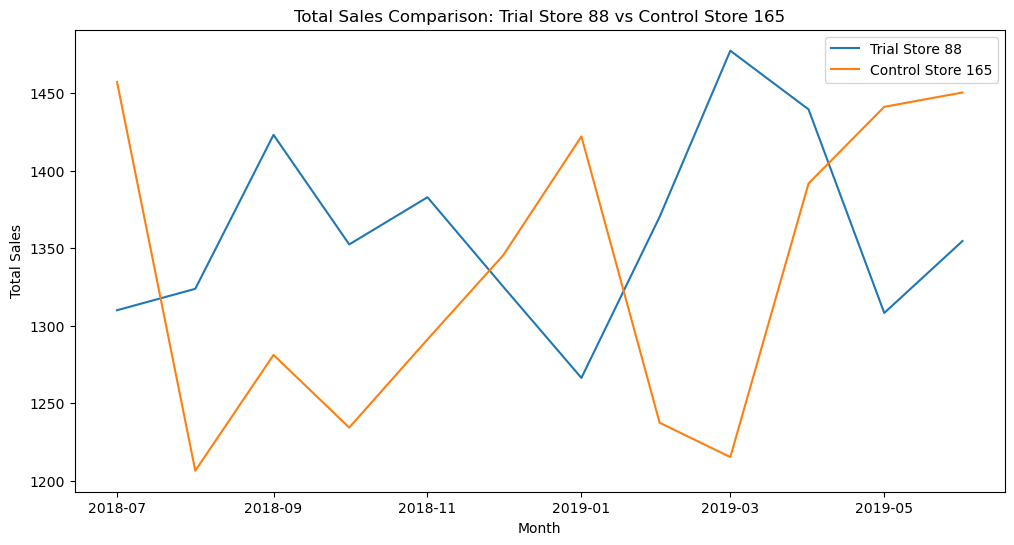

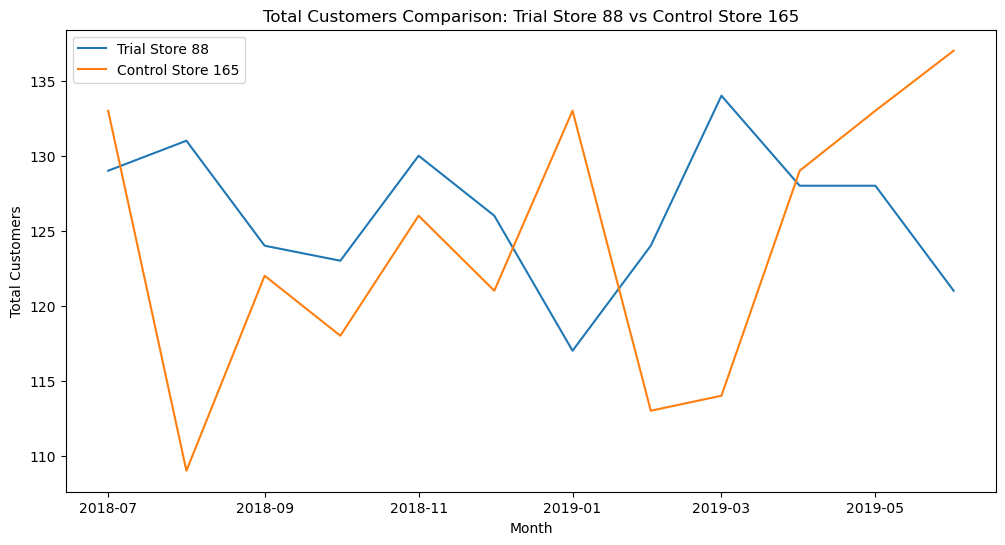

Statistical comparison of TOTAL_SALES:
 t-statistic = 0.8991550085580011, p-value = 0.38015152066183844


(0.8991550085580011, 0.38015152066183844)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

def compare_stores(trial_store, control_store, metrics):
    trial_data = metrics[metrics['STORE_NBR'] == trial_store]
    control_data = metrics[metrics['STORE_NBR'] == control_store]

    # Suppress the FutureWarning during plotting
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)

        # Plot total sales comparison
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='MONTH', y='TOTAL_SALES', data=trial_data, label=f'Trial Store {trial_store}')
        sns.lineplot(x='MONTH', y='TOTAL_SALES', data=control_data, label=f'Control Store {control_store}')
        plt.title(f'Total Sales Comparison: Trial Store {trial_store} vs Control Store {control_store}')
        plt.xlabel('Month')
        plt.ylabel('Total Sales')
        plt.legend()
        plt.show()

        # Plot total customers comparison
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='MONTH', y='TOTAL_CUSTOMERS', data=trial_data, label=f'Trial Store {trial_store}')
        sns.lineplot(x='MONTH', y='TOTAL_CUSTOMERS', data=control_data, label=f'Control Store {control_store}')
        plt.title(f'Total Customers Comparison: Trial Store {trial_store} vs Control Store {control_store}')
        plt.xlabel('Month')
        plt.ylabel('Total Customers')
        plt.legend()
        plt.show()

    # Statistical comparison
    t_stat, p_value = stats.ttest_ind(trial_data['TOTAL_SALES'], control_data['TOTAL_SALES'], equal_var=False)
    print(f'Statistical comparison of TOTAL_SALES:\n t-statistic = {t_stat}, p-value = {p_value}')
    return t_stat, p_value

# Example comparison
compare_stores(77, 46, metrics)
compare_stores(86, 247, metrics)
compare_stores(88, 165, metrics)
